In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from scipy.sparse.linalg import LinearOperator, gmres, bicgstab
from functools import partial
import pyopencl as cl
import inspect
import math
from random import seed, randint

# Create some context
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

In [2]:
def solve_timedep_poisson(U, sigma, Nx, Ny, Nt):
    """
    Calculates the solution to the time dependent equation from stage 2
    by calculating the solution each time step in parallel using an 
    OpenCL kernel.
    
    Inputs: 
    - Nx:           The number of gridpoints in x space
    - Ny:           The number of gridpoints in the y space
    - Nt:           The number of timesteps 
    - sigma:        A known field function in the x, y space
    - U:            A 1D vector of length Nx*Ny representing the x,y space.
                    The components of U have been stack horizontally. i.e., 
                    U[i] represents co-ordinate ( (i%Nx)*dx, int(i/Nx)*dy )
                    where, dx, dy are the grid spacings in x and y
    """
    
    # Define kernel used to calculate RHS operator in parallel 
    kernel = """
    
    __kernel void poissonOperator(__global double *U,
                                  __global double *U_tp1,
                                  __global double *sigma,
                                  const int Nx,
                                  const int Ny,
                                  const int Nt)
    {
        //------------------------------------------------------------------------------------------
        // An OpenCL Kernel that calculates u_(t+1) = u_t + dt*A in parallel using Nx*Ny work items.
        // Where A is the poisson operator described in the coursework.
        //
        // Variables: 
        // U:                        Nx*Ny length vector containing solution at the current time, t
        // Utp1:                     Nx*Ny length vector containing soln at t+dt 
        // Nx, Ny, Nt, sigma:        See above.
        //------------------------------------------------------------------------------------------
    
        int gid = get_global_id(0);
        
        double dx = 1.0/Nx;
        double dy = 1.0/Ny;
        double dt = dx*dx/5;
        
        // Boundary conditions
        if(gid < Nx || gid > Nx*(Ny-1) - 1 || gid%Nx == 0 || (gid+1)%Nx == 0)
        {
            U_tp1[gid] = 0.0;
        }
        else
        {
            U_tp1[gid] = U[gid] + dt * ( 1/(2*dx*dx)
                                         * ( (sigma[gid+1] + sigma[gid]) * (U[gid+1] - U[gid])
                                         - (sigma[gid-1] + sigma[gid]) * (U[gid] - U[gid-1]) )
                                       + 1/(2*dy*dy) 
                                         * ( (sigma[gid+Nx] + sigma[gid]) * (U[gid+Nx] - U[gid])
                                         - (sigma[gid-Nx] + sigma[gid]) * (U[gid] - U[gid-Nx]) ));
        } 
    }
    
    """
    
    
    mf = cl.mem_flags    
    work_items = Nx*Ny
    
    # Initialise result 
    result = np.zeros((Nt, Nx*Ny), dtype=np.float64)
    
    # Define kernel buffers
    U_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=U)
    result_buffer = cl.Buffer(ctx, mf.ALLOC_HOST_PTR | mf.WRITE_ONLY, size=len(U) * 8)
    sigma_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=sigma)
    kernel_args = (U_buffer, result_buffer, sigma_buffer, np.int32(Nx), np.int32(Ny), np.int32(Nt))
    
    prg = cl.Program(ctx, kernel)
    prg.build()
    potential_kernel = prg.poissonOperator
    
    ##############################################################################################
    # Compute RHS in parallel at each timestep
    for t in range(Nt):
    
        potential_kernel(queue, (work_items, ), (1, ), *kernel_args) 

        result[t, :], _ = cl.enqueue_map_buffer(queue, result_buffer, cl.map_flags.READ,
                                          0, (work_items, ), np.double)
        
        cl.enqueue_copy(queue, U_buffer, result_buffer)
    ##############################################################################################
    
    return result

In [3]:
def initialCondition(Nx, Ny, condition):
    """
    Initialises various I.Cs on an x,y
    grid with Nx & Ny grid spacings in the x and 
    y space respectively.
    
    Returns a 1d vector of length Nx*Ny 
    """
    U = np.zeros((Nx,Ny), dtype=np.float64)
    dx = np.float64(1/(Nx-1))
    dy = np.float64(1/(Ny-1))

    if (condition == 'sin'):
        # U(x,y,t=0) = sin(pi*x)*sin(pi*y)
        
        for i in range(Nx):
            for j in range(Ny):
                U[i][j] = np.sin(np.pi*i*dx)*np.sin(np.pi*j*dy)
    
    elif(condition == 'sin2'):
         # U(x,y,t=0) = sin(2*pi*x)*sin(2*pi*y)
        
        for i in range(Nx):
            for j in range(Ny):
                U[i][j] = np.sin(2*np.pi*i*dx)*np.sin(2*np.pi*j*dy)
                
    elif(condition == 'sin3'):
        # U(x,y,t=0) = sin(2pi*x)*sin(pi*y)
        
        for i in range(Nx):
            for j in range(Ny):
                U[i][j] = np.sin(2*np.pi*i*dx)*np.sin(np.pi*j*dy)
                    
    elif(condition == 'linear'):
        # U(x,y,t=0) = x + y
        
        for i in range(Nx):
            for j in range(Ny):
                U[i][j] = i*dx + j*dy

    elif(condition == 'singlepoint'):
        # U(x,y,t=0) = 1 at x=0.5, y=0.5
        #            = 0 elsewhere
        
        U[np.int(Nx/2)][np.int(Ny/2)] = 1
        
    elif(condition == 'randpoint1'):
        # U(x,y,t=0) = 1 at 5 rand points
        #            = 0 elsewhere
        
        seed(2)
        
        U[randint(1,Nx)][randint(1,Ny)] = 1
        U[randint(1,Nx)][randint(1,Ny)] = 1
        U[randint(1,Nx)][randint(1,Ny)] = 1        
        U[randint(1,Nx)][randint(1,Ny)] = 1
        U[randint(1,Nx)][randint(1,Ny)] = 1
        
    elif(condition == 'randpoint2'):
        # same as randpoint1 but w/ some 
        # negative points
        seed(2)
        
        U[randint(1,Nx)][randint(1,Ny)] = 1
        U[randint(1,Nx)][randint(1,Ny)] = -1
        U[randint(1,Nx)][randint(1,Ny)] = 1        
        U[randint(1,Nx)][randint(1,Ny)] = -1
        U[randint(1,Nx)][randint(1,Ny)] = 1
        
    else:
        raise Exception("Invalid initial condition")
                    
        
    return np.hstack(U)



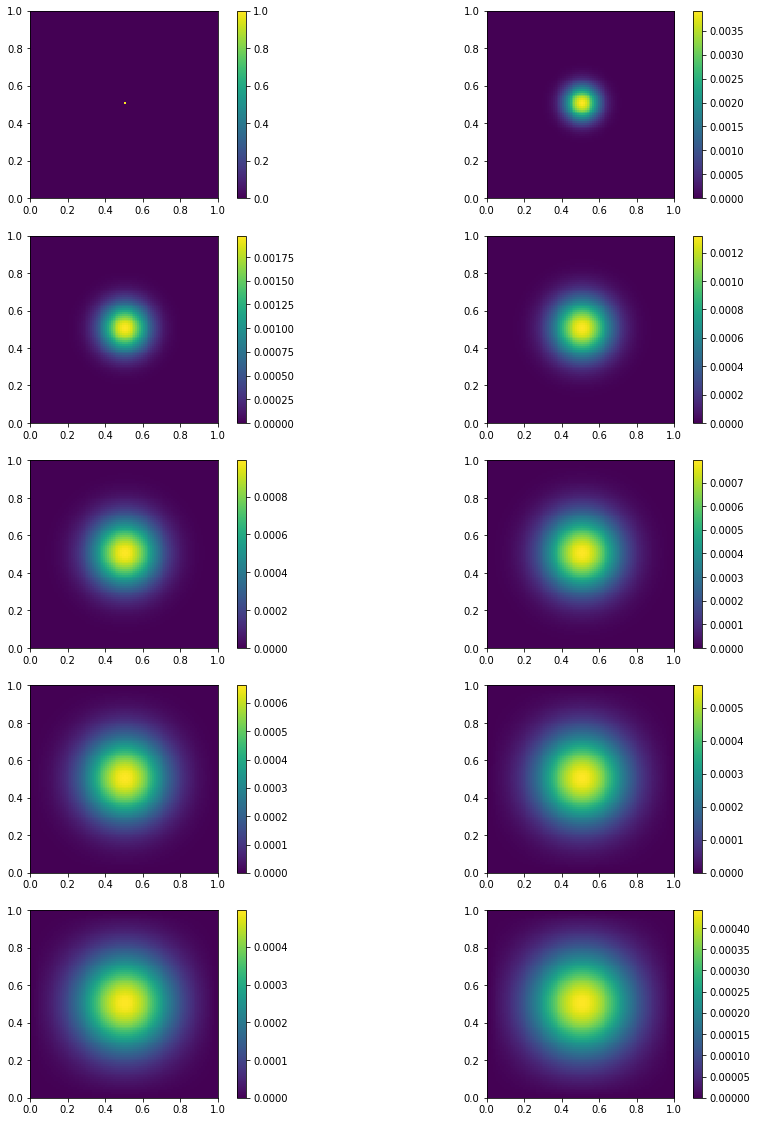

In [8]:
######################################################################
# Initialise problem
#-------------------
Nx = 100
Ny = 100
Nt = 1000
 
#normal_dist = np.random.normal(1, 0, (Nx+1)*(Ny+1))
#sigma = np.exp(normal_dist)
sigma = np.ones(Nx*Ny, dtype=np.float64)
# NOTE: Introducing variance field requires smaller dt and more iterations 
#       sin() initial condition becomes especially sensitive 

U = initialCondition(Nx, Ny, 'singlepoint')
#######################################################################
    
#######################################################################
# Solve solution 
#------------------------
steps = solve_timedep_poisson(U, sigma, Nx, Ny, Nt)
#######################################################################

#######################################################################
# Plot M (even) solutions from t=0 -> t = Nt*dt
M=10
plot_step = np.int(Nt/(M))

plt.subplots(5,2,figsize=(15,20))

count = 1
for timestep in range(0, Nt, plot_step):
    step = np.resize(steps[timestep,:], (Ny, Nx))
    
    plt.subplot(5,2,count)    
    count += 1
    
    if(timestep==0):
        U = np.resize(U, (Ny, Nx))
        plt.imshow(np.flipud(U), extent=[0, 1, 0, 1])
        plt.colorbar()    
    else:
        plt.imshow(np.flipud(step), extent=[0, 1, 0, 1])
        plt.colorbar()
    
plt.show()
########################################################################




In [6]:
######################################################################
# Timing Solution for 10 Timesteps
#---------------------------------
from time import time
######################################################################

######################################################################
# Initialise problem
#-------------------
Nx = 100
Ny = 100
Nt = 10
 
#normal_dist = np.random.normal(1, 0.1, (Nx+1)*(Ny+1))
#sigma = np.exp(normal_dist)
sigma = np.ones(Nx*Ny, dtype=np.float64)
# NOTE: Introducing variance field requires smaller dt and more iterations 
#       sin() initial condition become especially sensitive 

U = initialCondition(Nx,Ny,'singlepoint')
#######################################################################

#######################################################################
# Timing Solution 
#----------------
st = time()
res = solve_timedep_poisson(U, sigma, Nx, Ny, Nt)
et = time()
print("Elapsed time (s): {0}".format(et - st))
########################################################################


Elapsed time (s): 0.021271228790283203
